In [1]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from seaborn import set_style
set_style("darkgrid")
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Okt', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [4]:
print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(int),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("../input/train_filled_gap.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("../input/test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("../input/store.csv")

Load the training, test and store data using pandas


In [5]:
print("Assume store open, if not provided")
test.fillna(1, inplace=True)

# print("Consider only open stores for training. Closed stores wont count into the score.")
# train = train[train["Open"] != 0]
# print("Use only Sales bigger then zero")
# train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
train = build_features(features, train)
test = build_features([], test)
print(features)

print('training data processed')

Assume store open, if not provided
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed


What must be forecasted ? The sales per store. For what period ?

In [6]:
print ('From',test.Date.min(),'to', test.Date.max())
print ('That is', test.Date.max()-test.Date.min(), 'days')

From 2015-08-01 00:00:00 to 2015-09-17 00:00:00
That is 47 days 00:00:00 days


For how many stores ?

In [7]:
test.Store.nunique()

856

Let's take a random store from the trainings data and plot how the Sales data looks like

In [8]:
rS = 979 # rS =  random.choice(train.Store.unique())
print ('Random store number =', rS)

Random store number = 979


How many year's of data do we have in the trainingset?

In [9]:
train.Year.unique()

array([2013, 2014, 2015])

Let look at the sales of store 979 in 2013

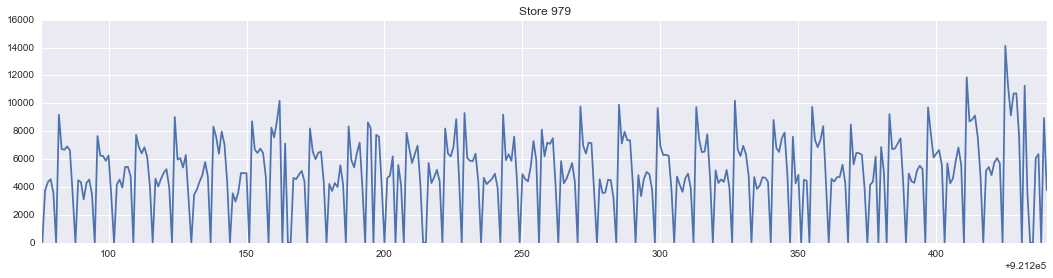

In [10]:
train[(train.Store==rS) & (train.Year==2013)].Sales.plot(label='2013', figsize=(18,4))
plt.title('Store {}'.format(rS))
plt.show()

We see some patters emerge. Let's make Date the index so that we have date's at the x-axis.

In [11]:
train.set_index('Date', inplace=True)

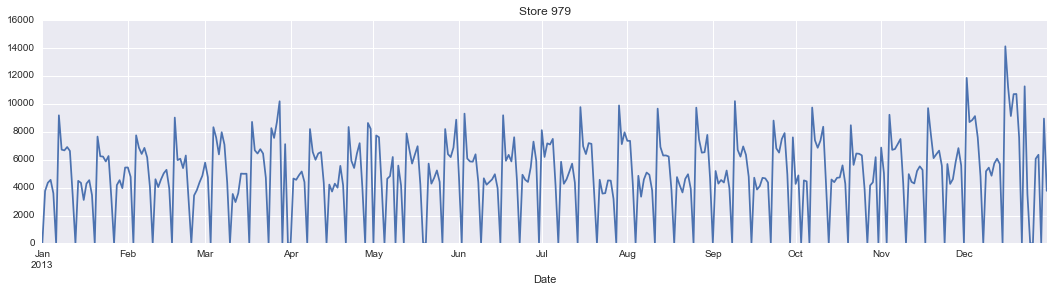

In [12]:
st = train[train.Store==rS] # Select store rS
st['2013']['Sales'].plot(label='2013', figsize=(18,4), title='Store {}'.format(rS))
plt.show()

The sharp needles in the Sales that touch the zero axis are the sunday's.
The reason is that on Sunday most store are not open
and have no sales. Let's check that by summing all sales on Sunday's:

In [13]:
train[train.DayOfWeek==6].Sales.sum()

29551433.0

This should be zero. How come it's not?
The reason is that some store's are occasionally open on sunday:    

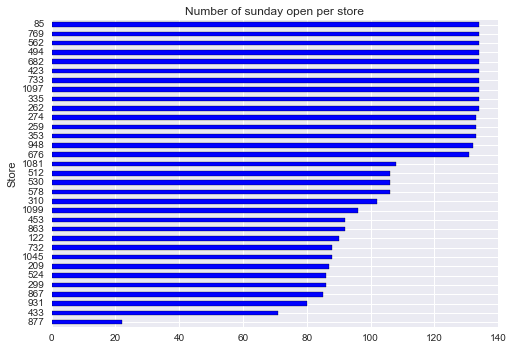

In [14]:
salesOnSundayPerStore = train[(train.Open) & (train.DayOfWeek==6)].groupby('Store')['Sales']
salesOnSundayPerStore.count().sort_values().plot(kind='barh')
plt.title('Number of sunday open per store')
plt.show()

Indeed, store number 85 had many open days on sunday:

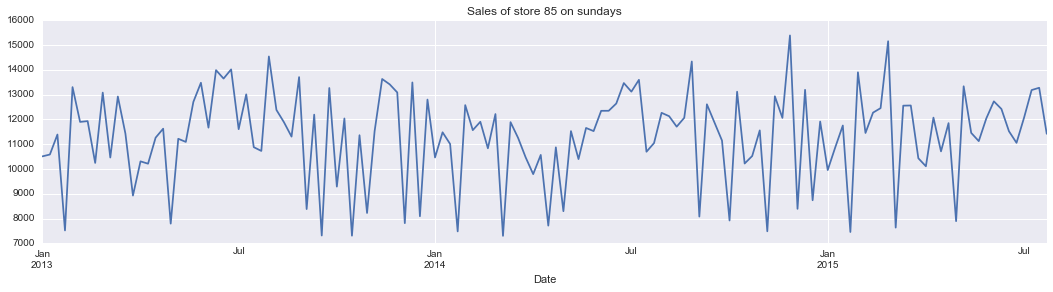

In [15]:
train[(train.Store==85) & (train.DayOfWeek==6)].Sales.plot(figsize=(18,4))
plt.title('Sales of store 85 on sundays')
plt.show()

Let's take a look to the sales of the store 979 and search for patterns.

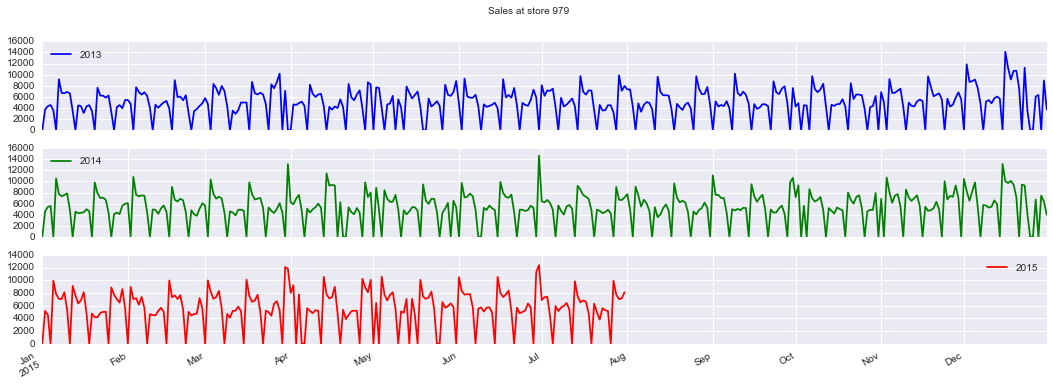

In [16]:
# fig, axes = plt.subplots(3, 1, figsize=(18, 4));
def plotStore(rS):
    st = train[train.Store==rS]
    storerS13 = st[st.Year==2013].Sales.reset_index(drop=True)
    storerS14 = st[st.Year==2014].Sales.reset_index(drop=True)
    storerS15 = st[st.Year==2015].Sales.reset_index(drop=True)

    df_plot = pd.concat([storerS13, storerS14, storerS15], axis=1)
    df_plot.columns = ['2013', '2014', '2015']
    df_plot.index = pd.date_range('1/1/2015', periods=365, freq='D')
    df_plot.plot(subplots=True,figsize=(18, 6), title='Sales at store {}'.format(rS))
    plt.show()
plotStore(rS)

From above chart, are task is clear. We have to predict how the read curve is continuing for
48 days starting from the first of august until and included 19 september. We can also spot
some patterns. Peak's are the beginning of every month. The second week have rather constant
sales. On the beginning of the third week, we see again peak altough a bit smaller than the
beginning of the month. The reason for this patterns is probably paycheck days typically at
the beginning of the month or in the middle of the month. Also in 2014 and 2015 we see a big peak in the beginning of July but not in 2013. Maybe a lot of Germans got extra holdiday money in 2014 and 2015 on there paycheck in July? Let's check another store.

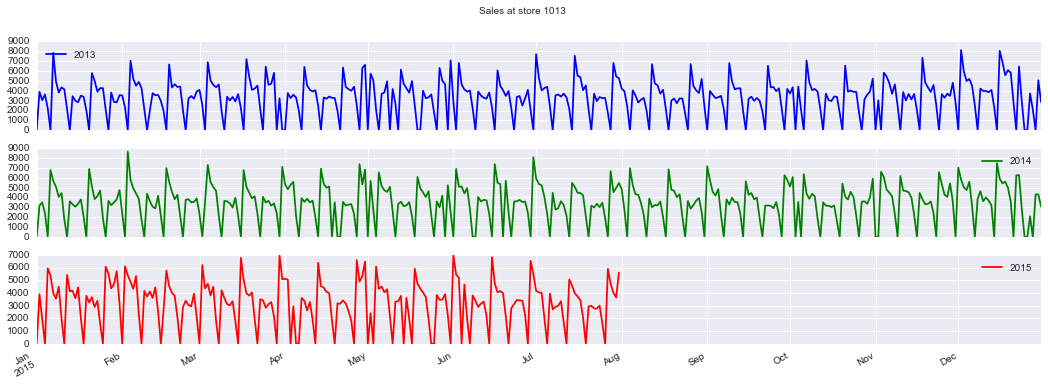

In [17]:
rS = 1013  # rS =  random.choice(train.Store.unique())
plotStore(1013)

Store 1013 has no extra big peak beginning of July.
Let check another store. 

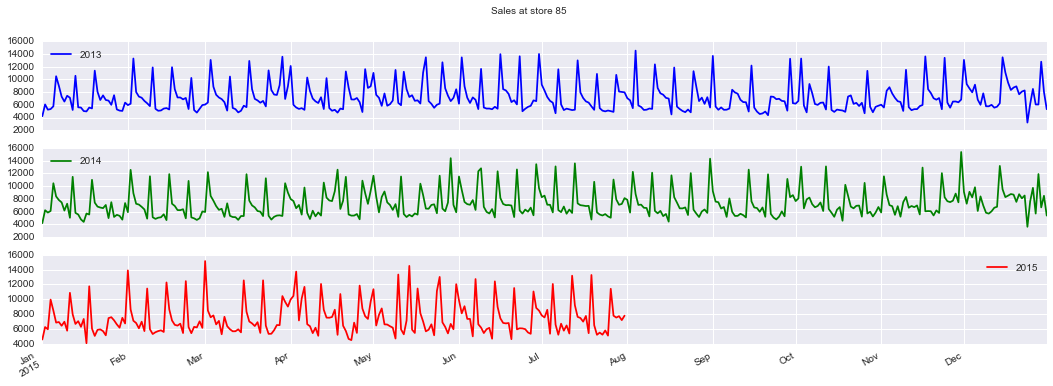

In [18]:
rS =  85 #random.choice(train.Store.unique())
plotStore(rS)

Store 85 looks different. Remeber store 85 ? It's the store that is open on sundays a lot. Let check another store 
that is open on sunday a lot: store 769.

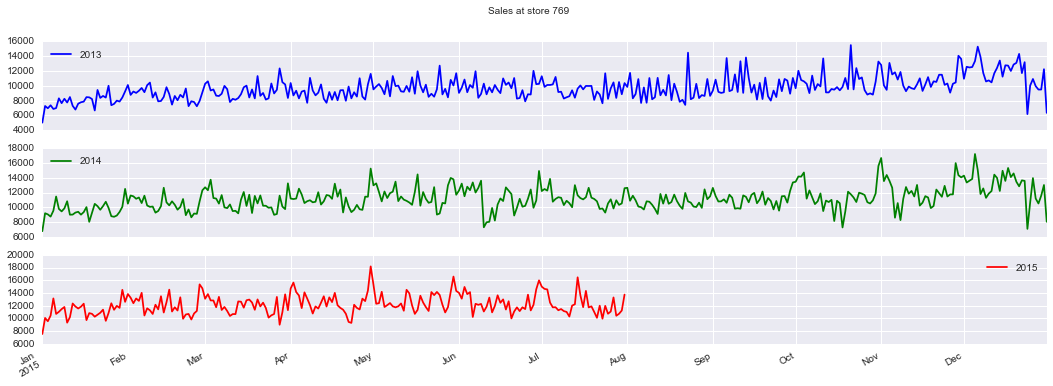

In [19]:
plotStore(769)

We are lucky because neither store 86 nor store 769 are to be predicted so we can ingnore them. Still have to check
for the other stores later.

# First Prediction
Sales look rather a constant repeating pattern. Let's exploit that pattern to make a prediction. The most basic assuption could be that sales of the store in same period but one or two year ago are a good prediction for this year. Let's take the mean of August and the first two weeks of September in 2013 and 2014 as prediction:
<img src="http://i.imgur.com/3ii8Y0I.png" />

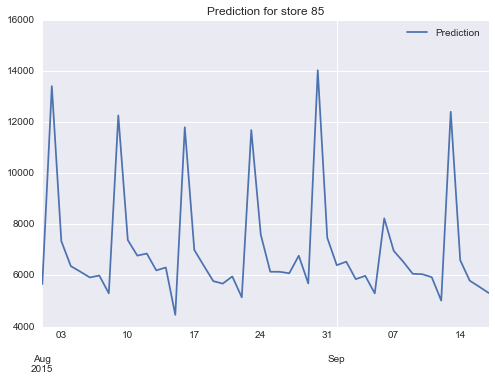

In [20]:
trainStore = train[train.Store == rS]
prevy1 = trainStore.ix['2014-08-02':'2014-09-18']['Sales'].reset_index(drop=True)
prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)
df_plot = pd.DataFrame(meanSales, index = pd.date_range('8/1/2015', periods=48, freq='D'))
df_plot.columns = ['Prediction']
df_plot.plot(title='Prediction for store {}'.format(rS));

Hoeray, we got our first prediction! Let's make a plot to find out how our prediction looks
with respect to the trainings data.

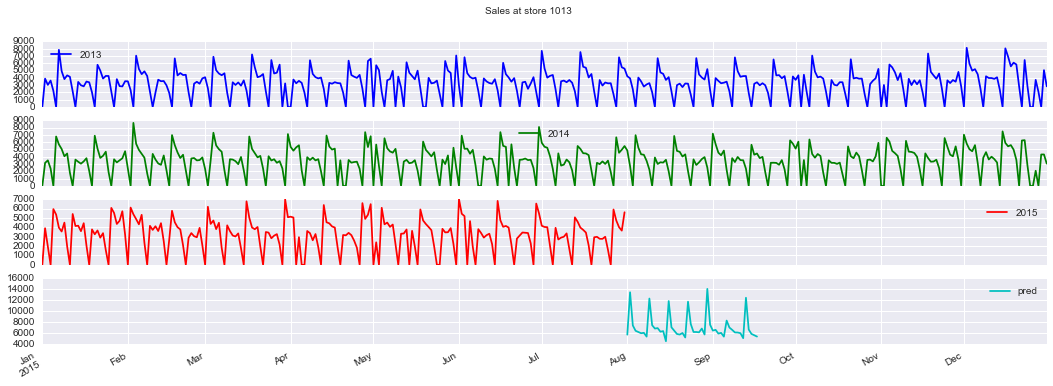

In [21]:
rS = 1013  # rS =  random.choice(train.Store.unique())
storerS13 = train[(train.Store==rS) & (train.Year==2013)].Sales.reset_index(drop=True)
storerS14 = train[(train.Store==rS) & (train.Year==2014)].Sales.reset_index(drop=True)
storerS15 = train[(train.Store==rS) & (train.Year==2015)].Sales.reset_index(drop=True)

df_plot = pd.concat([storerS13, storerS14, storerS15], axis=1)
df_plot.columns = ['2013', '2014', '2015']
df_plot.index = pd.date_range('1/1/2015', periods=365, freq='D')
df_plot['pred'] = pd.DataFrame(meanSales, index = pd.date_range('8/1/2015', periods=48, freq='D'))
df_plot.plot(subplots=True,figsize=(18, 6), title='Sales at store {}'.format(rS))
plt.show()

Let's look to our prediction in 2015 alone:

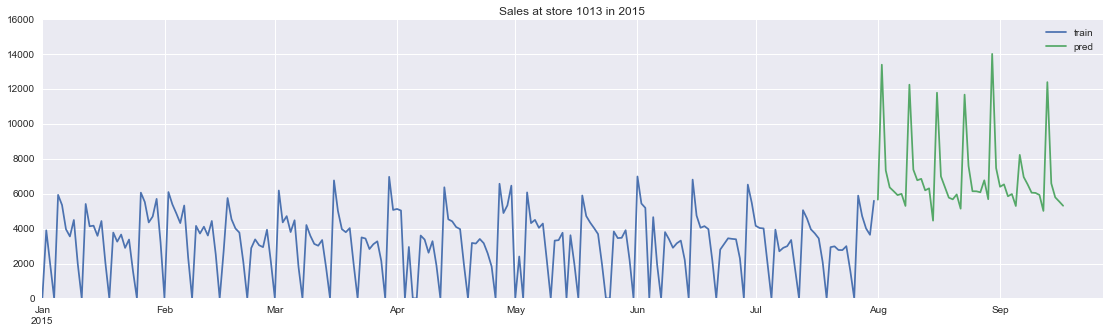

In [22]:
def plotTrainPred(rS, pred, title=None):
    trainStore = train[train.Store==rS]
    plotIndex = pd.date_range('1/1/2015', periods=270, freq='D')
    df_plot = pd.DataFrame(trainStore['2015']['Sales'], index = plotIndex)
    df_plot.columns = ['2015']
    predIndex = pd.date_range('8/1/2015', periods=48, freq='D')
    df_plot['pred'] = pd.DataFrame(pred, index = predIndex)
    df_plot['2015'].plot(label='train')
    if title:
        df_plot['pred'].plot(label='pred', figsize=(19, 5), title=title)
    else:
        df_plot['pred'].plot(label='pred', figsize=(19, 5), title='Sales at store {} in 2015'.format(rS))
    plt.legend();

plotTrainPred(1013, meanSales)

We spot two problems with our prediction. The first problem has to do with the size of our patterns. Beginning of month sale in 2015 are peaking between 6000 and 7000. Our prediction has peaks between 12000 adn 14000.
That looks like a scaling problem. The second problem is that sales for store 1013 are anticyclical in 2013 with respect to 2014. The result is that the two week pattern in our prediction is gone! Before we tackle those problems, let's check another store.

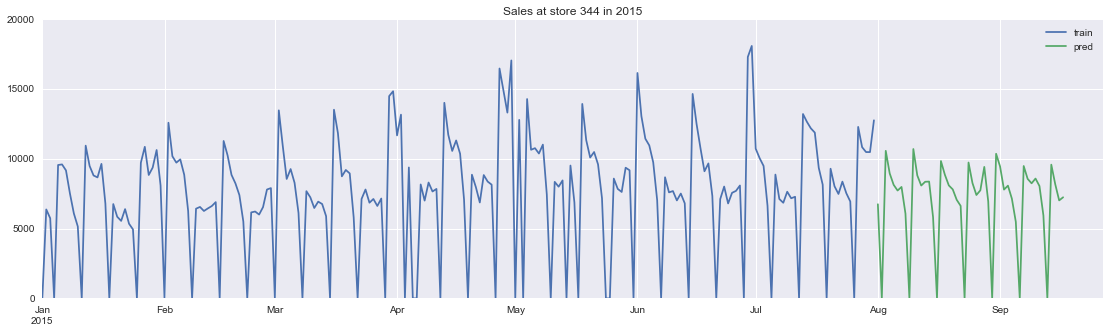

In [23]:
rS = 344 # rS =  random.choice(train.Store.unique())
trainStore = train[train.Store == rS]
prevy1 = trainStore.ix['2014-08-02':'2014-09-18']['Sales'].reset_index(drop=True)
prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)

plotTrainPred(344, meanSales)

Same problems in store 344. But here we have to scale up. Let check another store.

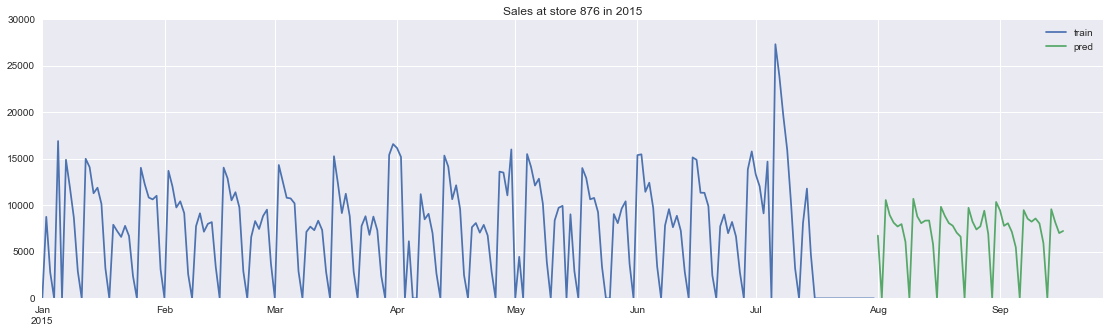

In [24]:
rs= 876 # rS =  random.choice(train.Store.unique())
trainStore = train[train.Store == rS]
prevy1 = trainStore.ix['2014-08-02':'2014-09-18']['Sales'].reset_index(drop=True)
prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)

plotTrainPred(876, meanSales)

Store 876 is missing data in the last two weeks of July in 2015. Lukily our simple prediction model only
use data from 2013 and 2014. 
Iterating above code several times with the random choise (see the comment) learns that all sales peaks differ
between 2013 and 2014. Moreover the pattern changes around 1 August 2014. The last week of July 2014 is a peak but the first weak of August 2014 too !
Lets check some other stores:

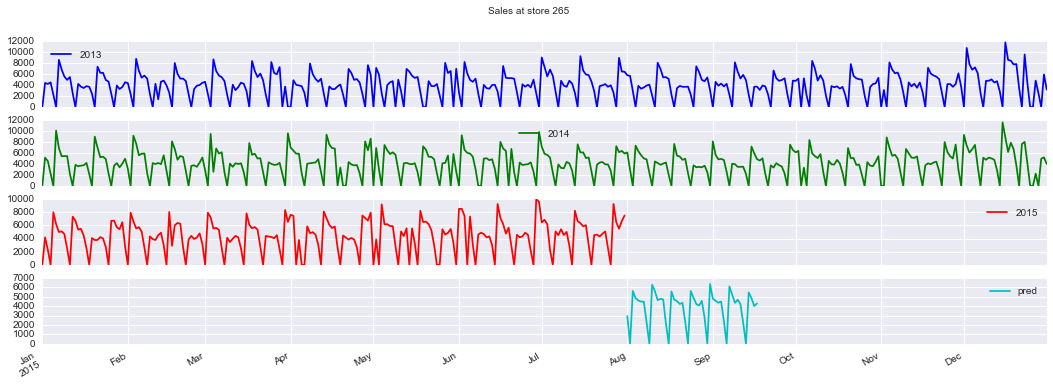

In [25]:
rS = 265 # random.choice(train.Store.unique())
trainStore = train[train.Store == rS]
prevy1 = trainStore.ix['2014-08-02':'2014-09-18']['Sales'].reset_index(drop=True)
prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)

storerS13 = train[(train.Store==rS) & (train.Year==2013)].Sales.reset_index(drop=True)
storerS14 = train[(train.Store==rS) & (train.Year==2014)].Sales.reset_index(drop=True)
storerS15 = train[(train.Store==rS) & (train.Year==2015)].Sales.reset_index(drop=True)

df_plot = pd.concat([storerS13, storerS14, storerS15], axis=1)
df_plot.columns = ['2013', '2014', '2015']
df_plot.index = pd.date_range('1/1/2015', periods=365, freq='D')
df_plot['pred'] = pd.DataFrame(meanSales, index = pd.date_range('8/1/2015', periods=48, freq='D'))
df_plot.plot(subplots=True,figsize=(18, 6), title='Sales at store {}'.format(rS))
plt.show()

Also store 265 (and a lot of other stores that I checked switch in the pattern around end of July 20014 and beginning
of August 2014. Let's use that for our prediction. Let's assume that the change in august is
only in 2014 and not in 2015. So we must start our prediction with a low week. We can do that
by taking the data from 2014 7 days further from the first saturday of august:
<img src="http://i.imgur.com/GrERfoZ.png" />

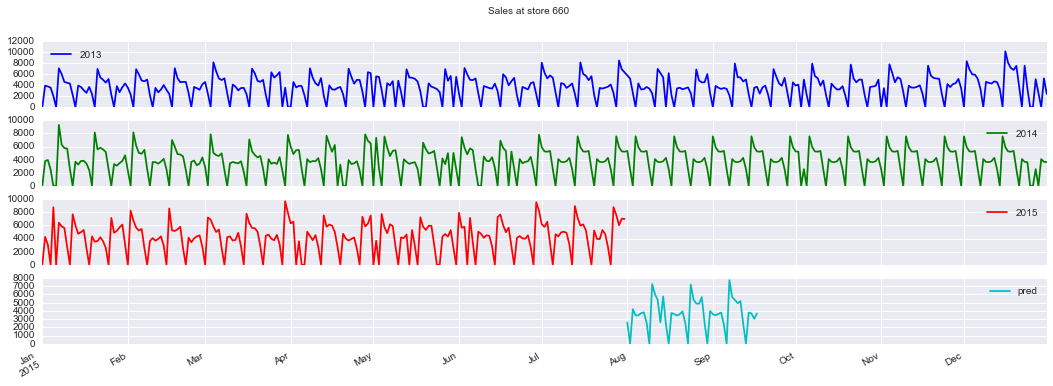

In [26]:
rS = 660 # random.choice(train.Store.unique())
trainStore = train[train.Store == rS]
prevy1 = trainStore.ix['2014-08-09':'2014-09-25']['Sales'].reset_index(drop=True)
prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)

storerS13 = train[(train.Store==rS) & (train.Year==2013)].Sales.reset_index(drop=True)
storerS14 = train[(train.Store==rS) & (train.Year==2014)].Sales.reset_index(drop=True)
storerS15 = train[(train.Store==rS) & (train.Year==2015)].Sales.reset_index(drop=True)

df_plot = pd.concat([storerS13, storerS14, storerS15], axis=1)
df_plot.columns = ['2013', '2014', '2015']
df_plot.index = pd.date_range('1/1/2015', periods=365, freq='D')
df_plot['pred'] = pd.DataFrame(meanSales, index = pd.date_range('8/1/2015', periods=48, freq='D'))
df_plot.plot(subplots=True,figsize=(18, 6), title='Sales at store {}'.format(rS))
plt.show()

See, the prediction for store 660 in august 2015 starts with a low week, has a peak in the second week, a low constant third week
and so on. Let's plot 2015 only:

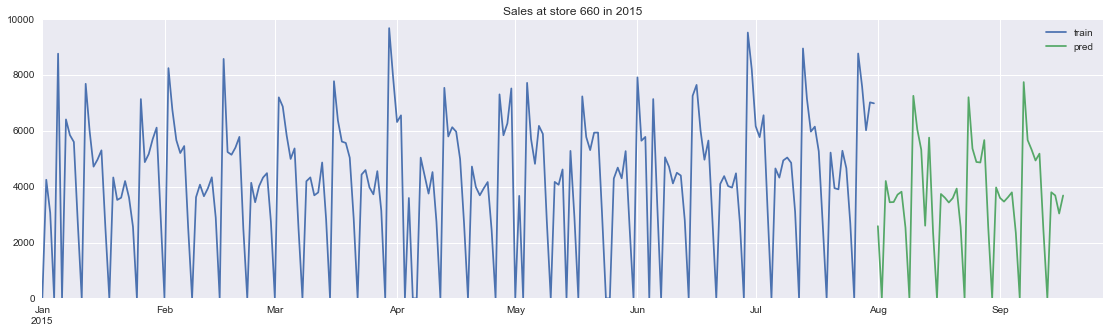

In [27]:
plotTrainPred(660, meanSales)

Okay, now the prediction for store 660 has the desired two weekly pattern but is still suffering
from a scaling issue. Peak sales in 2015 are around 10000 and our prediction peaks to 8000.
Let's scale our prediction. First find the peaks in 2015:

In [28]:
train[(train.Store==rS) & (train.Year==2015) & (train.Sales > 7000)]['Sales']

Date
2015-01-05    8771
2015-01-12    7691
2015-01-26    7143
2015-02-02    8254
2015-02-16    8583
2015-03-02    7206
2015-03-16    7785
2015-03-30    9686
2015-03-31    7924
2015-04-13    7547
2015-04-27    7313
2015-04-30    7526
2015-05-04    7725
2015-05-18    7241
2015-06-01    7922
2015-06-05    7144
2015-06-15    7261
2015-06-16    7652
2015-06-29    9529
2015-06-30    8210
2015-07-13    8957
2015-07-14    7158
2015-07-27    8778
2015-07-28    7592
2015-07-30    7027
Name: Sales, dtype: float64

Here we spot the pattern. Sales are peaking around the beginning of the month and in the middle the month. There are exception to this pattern but let's ignore them for a moment and concentrate on the beginning of the month first.

In [29]:
peakIndex= (train.Store==rS) & (train.Year==2015) & (train.Sales > 7500)
peakIndexStartMonth = peakIndex & ((train.Day > 26) | (train.Day < 6))
peakSalesStartMonth = train[peakIndexStartMonth]['Sales']
print (peakSalesStartMonth)
print ('Mean peak Sales beginning of the month', peakSalesStartMonth.mean())

Date
2015-01-05    8771
2015-02-02    8254
2015-03-30    9686
2015-03-31    7924
2015-04-30    7526
2015-05-04    7725
2015-06-01    7922
2015-06-29    9529
2015-06-30    8210
2015-07-27    8778
2015-07-28    7592
Name: Sales, dtype: float64
Mean peak Sales beginning of the month 8356.09090909


We still have more then one peak per month. Let's just take the maximum of each month:

In [30]:
train[(train.Store == rS)  & (train.Year == 2015)].groupby('Month')['Sales'].max()

Month
1    8771
2    8583
3    9686
4    7547
5    7725
6    9529
7    8957
Name: Sales, dtype: float64

The mean of the peak's:

In [31]:
trainrS15 = train[(train.Store == rS)  & (train.Year == 2015)]
meanPeaks=trainrS15.groupby('Month')['Sales'].max().mean()
print (meanPeaks)

8685.42857143


The maximum's per month in our prediction are:

In [32]:
predPeaks = df_plot['pred'].groupby(df_plot.index.month).max()
predPeaks[predPeaks.notnull()]

8    7262
9    7752
Name: pred, dtype: float64

The mean of the peak's:

In [33]:
predPeakMean = predPeaks[predPeaks.notnull()].mean()
print (predPeakMean)

7507.0


Let's scale our prediction and plot them (first unscaled for reference and then scaled):

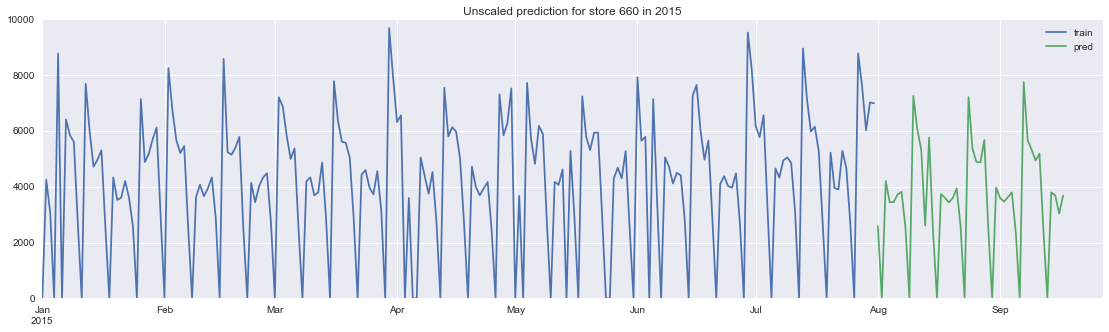

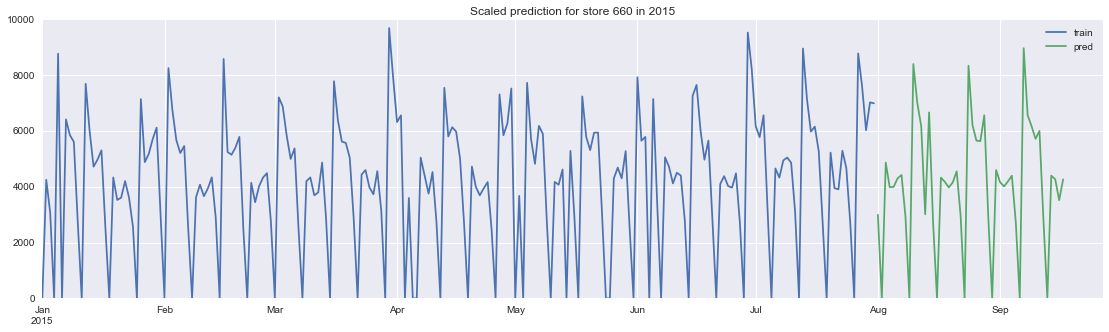

In [34]:
trainStore = train[train.Store == rS]
prevy1 = trainStore.ix['2014-08-09':'2014-09-25']['Sales'].reset_index(drop=True)
prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)
scaledMeanSales = meanSales * (meanPeaks/predPeakMean)
plotTrainPred(660, meanSales, 'Unscaled prediction for store 660 in 2015')
plt.show()
plotTrainPred(660, scaledMeanSales, 'Scaled prediction for store 660 in 2015')

Okay, the pattern and the scaling looks reasonably. Let's apply prediction for all the stores that must be predicted:

In [35]:
for rS in test.Store.unique():
    trainStore = train[train.Store == rS]
    prevy1 = trainStore.ix['2014-08-09':'2014-09-25']['Sales'].reset_index(drop=True)
    prevy2 = trainStore.ix['2013-08-03':'2013-09-19']['Sales'].reset_index(drop=True)
    meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)
    predRange = pd.date_range('8/1/2015', periods=48, freq='D')
    df_meanSales = pd.DataFrame(meanSales, index = predRange)
    meanPredPeaks = df_meanSales.groupby(df_meanSales.index.month).max().mean()
    trainrS15 = train[(train.Store == rS)  & (train.Year == 2015)]
    meanPeaks=trainrS15.groupby('Month')['Sales'].max().mean()
    pred = meanSales * (meanPeaks/predPeakMean)
    test.loc[test.Store == rS, 'Sales'] = pred

Let's check our prediction visually for some store's

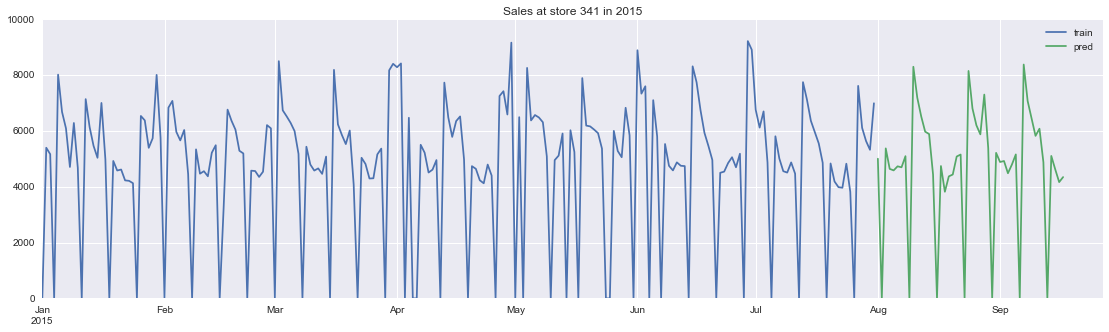

In [36]:
rS = 341 # random.choice(train.Store.unique())
plotTrainPred(341, test[test.Store==rS]['Sales'].values)

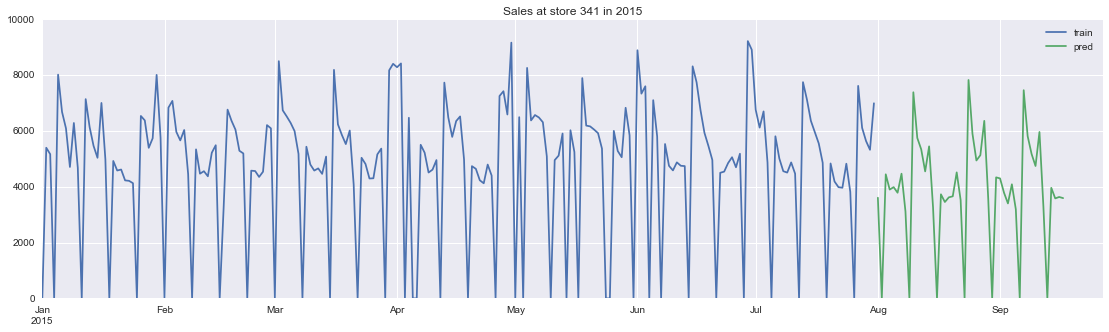

In [37]:
rS = 1047 # random.choice(train.Store.unique())
plotTrainPred(341, test[test.Store==rS]['Sales'].values)

The prediction for store's 341 and 1047 look promising. Let's make a submission and check the
score on the leaderboard.

In [38]:
test.loc[ test.Open == 0, 'Sales' ] = 0

result = pd.DataFrame({"Id": test["Id"], 'Sales': test['Sales']})
assert result.Sales.dropna().shape[0] == 41088
result.to_csv("timeserie_8_submission.csv", index=False)

Checking this prediction gives a really bad score of: 0.79625 ! Damn. There are some possibilities. Or there is some problem (an assumption error or a programming bug) in above code. Or the assumption about the first weeks and the pattern thereafter was the wrong choice. Let try the other assumption. There's peak in the last week of July 2015, a peak in the first week of august 2015, followed by a valley in week two of august 2015 and so on. We do this by averinging the series of sales starting in the second week in augustus 2013 (a peak) and the first week of august in 2014 (also a peak):
<img src='http://i.imgur.com/M27Z35N.png' />

In [39]:
for rS in test.Store.unique():
    trainStore = train[train.Store == rS]
    prevy1 = trainStore.ix['2014-08-02':'2014-09-18']['Sales'].reset_index(drop=True)
    prevy2 = trainStore.ix['2013-08-10':'2013-09-26']['Sales'].reset_index(drop=True)
    meanSales = np.mean(np.vstack((prevy1, prevy2)), axis=0)
    predRange = pd.date_range('8/1/2015', periods=48, freq='D')
    df_meanSales = pd.DataFrame(meanSales, index = predRange)
    meanPredPeaks = df_meanSales.groupby(df_meanSales.index.month).max().mean()
    trainrS15 = train[(train.Store == rS)  & (train.Year == 2015)]
    meanPeaks = trainrS15.groupby('Month')['Sales'].max().mean()
    pred = meanSales * (meanPeaks/predPeakMean)
    test.loc[test.Store == rS, 'Sales'] = pred

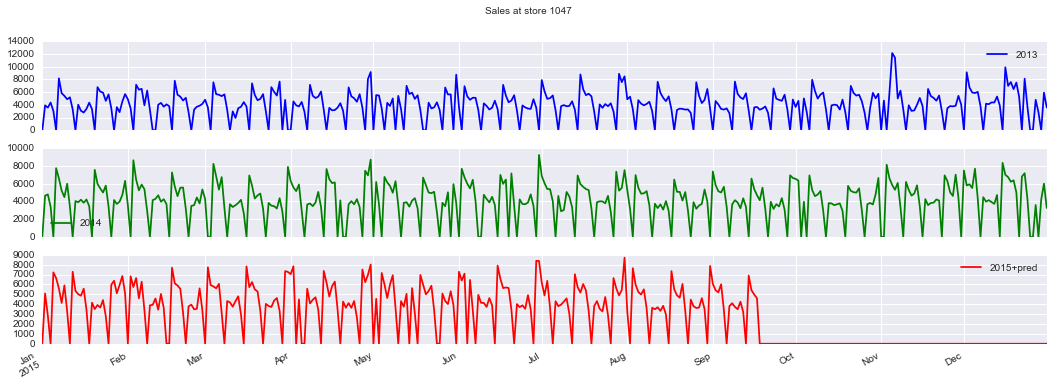

In [40]:
rS = 1047 # random.choice(train.Store.unique())
storerS13 = train[(train.Store==rS) & (train.Year==2013)].Sales.reset_index(drop=True)
storerS14 = train[(train.Store==rS) & (train.Year==2014)].Sales.reset_index(drop=True)
storerS15 = train[(train.Store==rS) & (train.Year==2015)].Sales.reset_index(drop=True)

df_plot = pd.concat([storerS13, storerS14, storerS15], axis=1)
df_plot.columns = ['2013', '2014', '2015']
df_plot.index = pd.date_range('1/1/2015', periods=365, freq='D')
pred = test[test.Store==rS]['Sales'].values
df_plot['pred'] = pd.DataFrame(pred, index = pd.date_range('8/1/2015', periods=48, freq='D'))
df_plot['2015+pred'] = df_plot['2015'].fillna(0) + df_plot['pred'].fillna(0)
df_plot[['2013','2014','2015+pred']].plot(subplots=True,figsize=(18, 6), title='Sales at store {}'.format(rS))
plt.show()

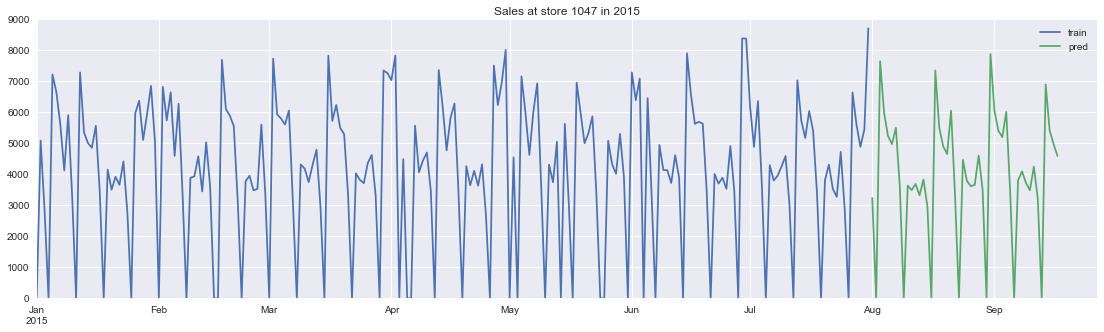

In [41]:
rS = 1047
plotTrainPred(1047, test[test.Store==rS]['Sales'].values)

In [42]:
test.loc[ test.Open == 0, 'Sales' ] = 0

result = pd.DataFrame({"Id": test["Id"], 'Sales': test['Sales']})
assert result.Sales.dropna().shape[0] == 41088
result.to_csv("timeserie_9_submission.csv", index=False)

This score even worse: 0.78191. Okay, back to the drawing board.

You probably think that applying the bazooka solution in the toolbelt of most datascientiest might help. Let's try XGBoost. The best public solution on the leaderboard (as of mon 16 november 2015) obtains a RMSPE of 0.10361 ! Let's download that solution and plot the solutions after training XGBoost for hour's and plot them for store's 341, 660, 1013 and 1047:

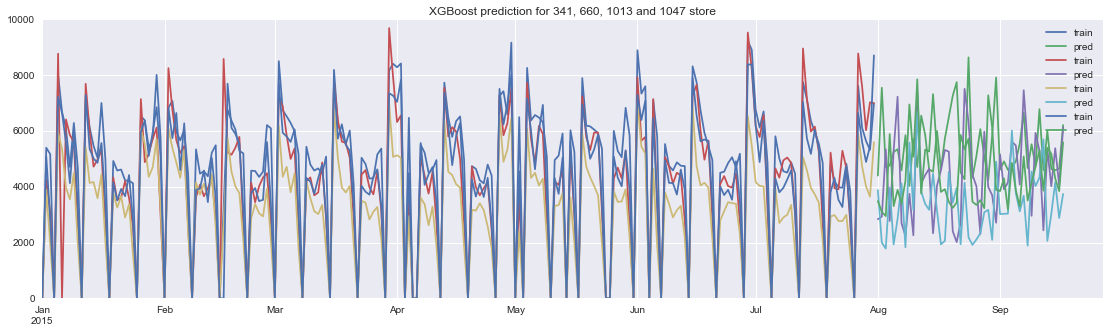

In [43]:
predValues = pd.read_csv('rf1.csv')
test.Sales = predValues.Sales
plotTrainPred(341, test[test.Store==341]['Sales'].values)
plotTrainPred(660, test[test.Store==660]['Sales'].values)
plotTrainPred(1013, test[test.Store==1013]['Sales'].values)
plotTrainPred(1047, test[test.Store==1047]['Sales'].values,title='XGBoost prediction for 341, 660, 1013 and 1047 store')

We see that sales for the four store have a reasonable pattern but that the prediction obtained trough XGBoost go in
all directions ! So, our simple timeserie approach was perhaps to simple but still promising. But that's for another weekend....